# When Will X's Next Album Be Released?

## Assumption
* Distance between albums is poisson distributed
* based on https://youtu.be/HTZaoK_h1A8?t=1451

## Progressions
* Time trend in distance between albums

## Data Pull

In [30]:
# x = "Bruce_Springsteen"
# x = "Taylor_Swift"
x = "Enter_Shikari"

In [31]:
url = f"https://en.wikipedia.org/wiki/{x}_discography"


dfs = pd.read_html(url)

In [32]:
df = dfs[1]
df.drop(df.tail(1).index, inplace=True)
df.columns = df.columns.droplevel()

try:
    df = df.rename(columns={"Details": "Album details"})
except Exception as e:
    print(e)

In [33]:
df["Release_date"] = pd.to_datetime(
    [
        " ".join(x.split(":")[1].split(" ")[:4]).split("[")[0]
        for x in df["Album details"]
    ]
)
df["album_delta"] = df["Release_date"].diff().dt.days
df["counts"] = 1
df

,Title,Album details,UK[1],UK Rock[2],UKIndie[3],AUS[4],BEL[5],GER[6],IRL[7],JPN[8],NLD[9],SCO[10],US[11],Certifications,Release_date,album_delta,counts
0,Take to the Skies,Released: 19 March 2007 Label: Ambush Reality ...,4,1,1,—,89,93,26,31,—,6,—,BPI: Gold[12],2007-03-19,nan,1
1,Common Dreads,Released: 15 June 2009 Label: Ambush Reality F...,16,—,—,55,94,96,—,77,—,22,—,BPI: Silver[13],2009-06-15,819.00000,1
2,A Flash Flood of Colour,Released: 16 January 2012 Label: Ambush Realit...,4,1,2,32,42,23,69,81,74,3,67,BPI: Silver[13],2012-01-16,945.00000,1
3,The Mindsweep,Released: 19 January 2015 Label: Ambush Realit...,6,2,1,19,68,17,59,142,26,8,166,NaN,2015-01-19,1099.00000,1
4,The Spark[14],Released: 22 September 2017 Label: Ambush Real...,5,2,1,56,68,60,—,—,—,4,—,NaN,2017-09-22,977.00000,1
5,Nothing Is True & Everything Is Possible[15],"Released: 17 April 2020 Label: SO Recordings, ...",2,1,2,—,80,35,—,—,—,2,—,NaN,2020-04-17,938.00000,1


In [34]:
df.index = pd.DatetimeIndex(df["Release_date"])

## Data Modeling

### Survival analysis 

In [35]:
pd.datetime.now()

datetime.datetime(2020, 5, 14, 20, 32, 29, 240530)

In [36]:
sdf = df[["album_delta", "counts"]].dropna().reset_index()
sdf.head()

,Release_date,album_delta,counts
0,2009-06-15,819.00000,1
1,2012-01-16,945.00000,1
2,2015-01-19,1099.00000,1
3,2017-09-22,977.00000,1
4,2020-04-17,938.00000,1


In [37]:
since = pd.DataFrame(
    data=[
        [pd.datetime.now()],
        [(pd.datetime.now() - sdf["Release_date"].max()).days],
        [0],
    ]
).T
current_days = (pd.datetime.now() - sdf["Release_date"].max()).days
since.columns = ["Release_date", "album_delta", "counts"]
since
# sdf = pd.concat([sdf, since])
sdf = sdf[sdf["album_delta"] > 0]
sdf

,Release_date,album_delta,counts
0,2009-06-15,819.00000,1
1,2012-01-16,945.00000,1
2,2015-01-19,1099.00000,1
3,2017-09-22,977.00000,1
4,2020-04-17,938.00000,1


## Modeling against wait times

https://blog.datank.ai/a-quick-introduction-to-pymc3-and-bayesian-models-part-i-65419bdffcd8

notes

* build gerneative model for possible observations
* build prior distribution for parameters of model

gamma
* unlikely (but possible) to release albums right after another release

In [38]:
# adding data
# Adding data. Note the extra parameter “observed” in the wait_times definition.

# We need to remove zeroes or we run into a bug!

with pm.Model() as model:
    rate_rate = 0.5
    rate = pm.Exponential("rate", rate_rate)
    alpha_prior = 2
    alpha = pm.Exponential("shape", alpha_prior)
    wait_times = pm.Gamma(
        "wait_times", beta=rate, alpha=alpha, observed=sdf["album_delta"].to_list()
    )  # Right here!
    next_wait_time = pm.Gamma("next_wait", beta=rate, alpha=alpha)

In [39]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, tune=5000)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:CompoundStep
INFO:pymc3:>Metropolis: [next_wait]
INFO:pymc3:>Metropolis: [shape]
INFO:pymc3:>Metropolis: [rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 40000/40000 [00:23<00:00, 1734.43draws/s]


C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000270FBB01898>,
      dtype=object)

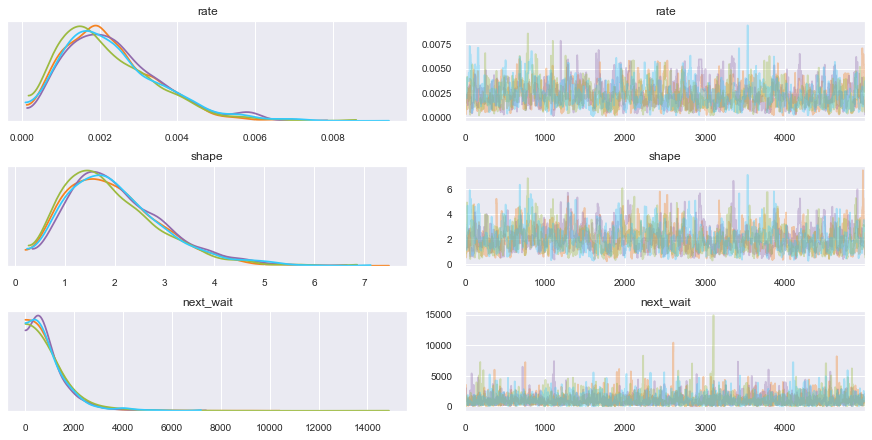

In [40]:
pm.plots.traceplot(trace)

(array([2.637e+03, 6.486e+03, 5.493e+03, 3.127e+03, 1.546e+03, 4.450e+02,
        2.130e+02, 3.900e+01, 6.000e+00, 8.000e+00]),
 array([9.38454164e-05, 1.02800030e-03, 1.96215519e-03, 2.89631008e-03,
        3.83046496e-03, 4.76461985e-03, 5.69877474e-03, 6.63292962e-03,
        7.56708451e-03, 8.50123940e-03, 9.43539428e-03]),
 <a list of 10 Patch objects>)

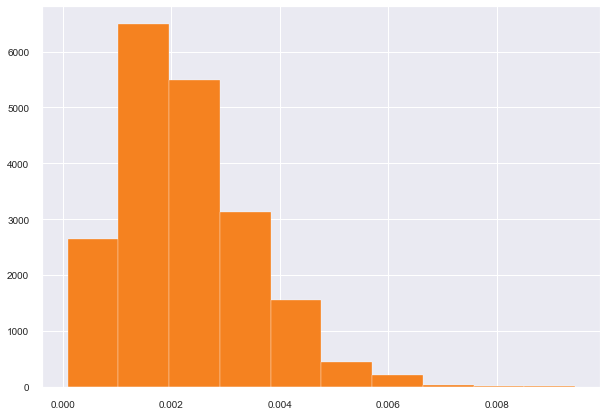

In [41]:
# The posterior distribution for the rate parameter. It encodes the uncertainty about it after observing the data.

plt.figure(figsize=(10, 7))
plt.hist(trace.rate)

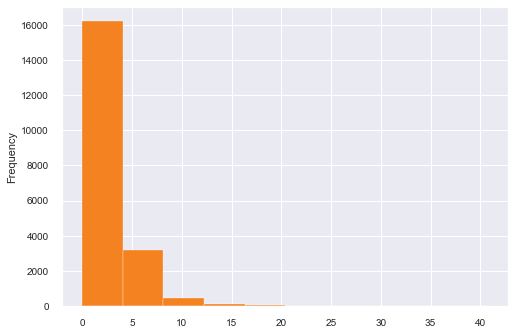

In [42]:
(pd.Series(trace["next_wait"]) / 365).plot.hist()

In [43]:
# How to compute probabilities using the posterior samples.
# We count the number of cases and divide by the total samples drawn.

post_samples = pd.Series(trace["rate"])

print("Expected rate: {}".format(post_samples.mean()))
print(
    "Probability between 0.15 and 0.158: {}".format(
        post_samples.map(lambda x: x > 0.15 and x < 0.158).mean()
    )
)
print(
    "Probability below 0.159: {}".format(post_samples.map(lambda x: x < 0.159).mean())
)

Expected rate: 0.0022916269852142667
Probability between 0.15 and 0.158: 0.0
Probability below 0.159: 1.0


In [44]:
posterior_samples = pm.sample_ppc(model=model, trace=trace, random_seed=4242)[
    "wait_times"
]

C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

sample_ppc() is deprecated.  Please use sample_posterior_predictive()

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:09<00:00, 2156.05it/s]


In [45]:
posterior_samples.shape = (posterior_samples.shape[0] * posterior_samples.shape[1],)
posterior_samples = posterior_samples / 365
posterior_samples.shape

(100000,)

In [46]:
ps = pd.Series(posterior_samples)
print(ps.mean())
print((ps > 10).mean())
print((ps < 1).mean())

2.624146673506292
0.01641
0.23506


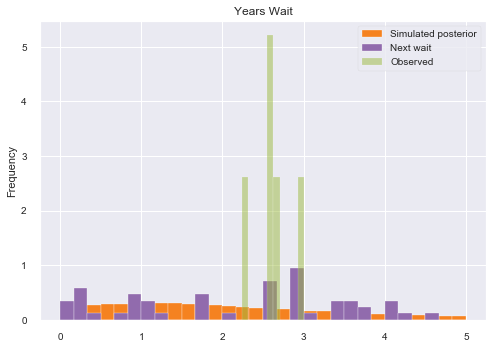

In [47]:
fig, ax = plt.subplots()
ax.hist(posterior_samples, range=(0, 5), bins=30, density=True, label="simulated")
ax.hist(trace["next_wait"], range=(0, 5), bins=30, density=True, label="next wait")


(sdf["album_delta"] / 365).plot.hist(
    density=True, ax=ax, alpha=0.5, title="Years Wait", label="Observed", legend=True
)
ax.legend(["Simulated posterior", "Next wait", "Observed"])
# sns.kdeplot(sdf["album_delta"] / 365, ax=ax)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270FB00F470>],
      dtype=object)

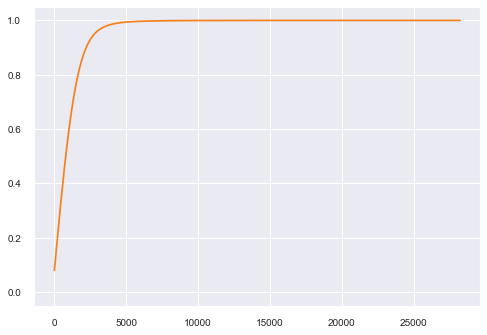

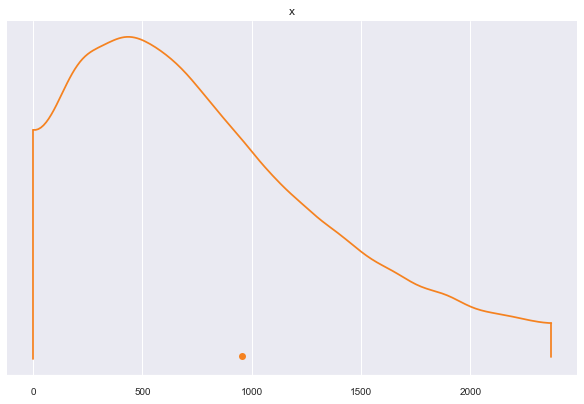

In [48]:
posterior_samples = posterior_samples * 365
pm.plots.kdeplot(posterior_samples, cumulative=True)
pm.plots.densityplot(posterior_samples)

In [49]:
stats = pm.stats.summary(trace["next_wait"]).T.to_dict()["x"]

## Data Prediction

In [50]:
display(pm.stats.summary(trace["next_wait"]))
display(pm.stats.summary(trace["next_wait"] / 365))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,962.72700,856.88800,0.07300,2357.85200,16.66700,11.78700,2643.00000,2643.00000,2423.00000,2553.00000,nan


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,2.63800,2.34800,0.00000,6.46000,0.04600,0.03200,2643.00000,2643.00000,2423.00000,2553.00000,nan


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270FB1E2160>],
      dtype=object)

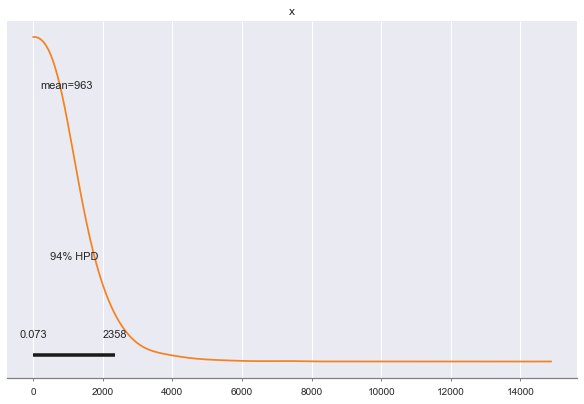

In [51]:
pm.plots.plot_posterior(trace["next_wait"])

In [52]:
print(
    "expected wait until next album (days): ",
    round((trace["next_wait"]).mean() - current_days),
    2,
)
print(
    "expected wait in months: ",
    round(((trace["next_wait"]).mean() - current_days) / 30),
    2,
)
print(
    "but could be up to ",
    round(stats["hpd_97%"] - current_days, 2),
    " days / ",
    round((stats["hpd_97%"] - current_days) / 30, 2),
    " months / ",
    round(((stats["hpd_97%"] - current_days) / 365), 2),
    " years.",
)

expected wait until next album (days):  936.0 2
expected wait in months:  31.0 2
but could be up to  2330.85  days /  77.7  months /  6.39  years.
